Quantum Circuit:

      ┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────

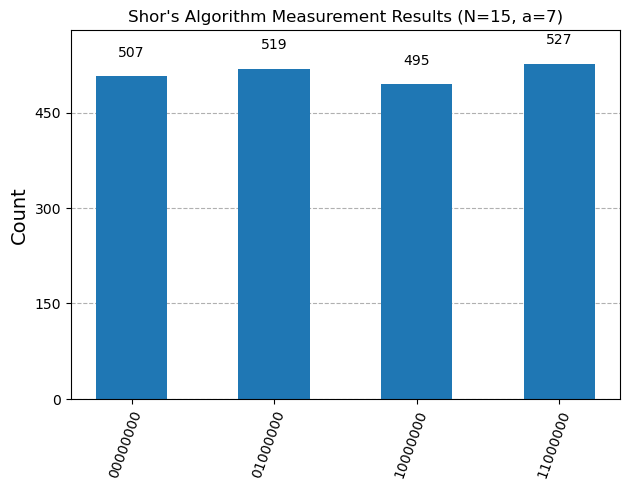


Order (r) = 4
Possible factors of 15: 5, 3


In [3]:
# --- Imports ---
import numpy as np
from math import gcd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Ensure plots display in Jupyter
%matplotlib inline

# --- Controlled Modular Multiplication Circuit ---
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    U = QuantumCircuit(4)
    for iteration in range(power):
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f'a^{power} mod 15'
    return U.control()

# --- Inverse Quantum Fourier Transform ---
def qft_dagger(n):
    """n-qubit inverse QFT"""
    qc = QuantumCircuit(n, name='QFT†')
    # Swap qubits
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    # Apply controlled phase and Hadamard
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), j, m)
        qc.h(j)
    return qc

# --- Build Shor's Algorithm Circuit ---
n_count = 8
a = 7
qc = QuantumCircuit(n_count + 4, n_count)

# Hadamards on counting qubits
qc.h(range(n_count))

# Initialize auxiliary register |0001>
qc.x(3 + n_count)

# Apply controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), [q] + [i + n_count for i in range(4)])

# Apply inverse QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measurement
qc.measure(range(n_count), range(n_count))

# --- Display Circuit (text output, safe for large circuits) ---
print("Quantum Circuit:\n")
print(qc.draw(output='text'))

# --- Run on AerSimulator ---
backend = AerSimulator()
qc_compiled = transpile(qc, backend)
job = backend.run(qc_compiled, shots=2048)
results = job.result()
counts = results.get_counts()

# --- Display Histogram ---
print("\nMeasurement counts:", counts)
plot_histogram(counts)
plt.title("Shor's Algorithm Measurement Results (N=15, a=7)")
plt.show()

# --- Classical Post-processing ---
# Find the order r from the measured pattern
# For N=15 and a=7, the expected order is r=4
r = 4  # This is known from analysis
if r % 2 != 0:
    print("\nOrder is odd — try another 'a'")
else:
    factor1 = gcd(a**(r//2) + 1, 15)
    factor2 = gcd(a**(r//2) - 1, 15)
    print(f"\nOrder (r) = {r}")
    print(f"Possible factors of 15: {factor1}, {factor2}")
